In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import gc
import random
import itertools
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import torch
import tokenizers
import transformers
from transformers import AutoTokenizer, EncoderDecoderModel, DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
import datasets
from datasets import load_dataset, load_metric
import sentencepiece
import argparse
from datasets.utils.logging import disable_progress_bar
from rdkit import Chem
import rdkit
disable_progress_bar()
import matplotlib.pyplot as plt

df = pd.read_csv('yield_prediction_output.csv')
df

,CATALYST,REACTANT,REAGENT,SOLVENT,INTERNAL_STANDARD,NoData,PRODUCT,YIELD,TEMP,input,prediction
0,,CCN(CC)CC.CCOC(=O)Cl.NCCC1(O)CCc2ccccc2C12CCCC2,,ClCCl,,,CC#CN1C(=O)C(C)Oc2ccc(-n3c(=O)cc(C(F)(F)F)[nH]...,98.0,,REACTANT:CCN(CC)CC.CCOC(=O)Cl.NCCC1(O)CCc2cccc...,58.379757
1,[Pd],CC(C)(C)OC(=O)N1Cc2cc([N+](=O)[O-])ccc2C[C@H]1...,,CO,,,c1ccc2sc(-c3nccc4ccccc34)cc2c1,84.0,,REACTANT:CC(C)(C)OC(=O)N1Cc2cc([N+](=O)[O-])cc...,94.428665
2,,CC(=O)NC[C@H]1CN(c2cc(F)c(N3CCS(=O)(=O)CC3)c(F...,,CC(=O)O,,,CCCCCCCCCCCC(=O)N1CCC[C@H]1C(=O)O,94.0,,REACTANT:CC(=O)NC[C@H]1CN(c2cc(F)c(N3CCS(=O)(=...,61.887108
3,,C#C[Si](C)(C)C.FC(F)(F)c1ccc(-c2ccc3ncc(I)n3c2...,,,,,COC(=O)c1nc(Br)cc(Br)c1OCc1ccccc1,89.0,,REACTANT:C#C[Si](C)(C)C.FC(F)(F)c1ccc(-c2ccc3n...,73.159970
4,,CC1CCC(Br)c2ncc(C(=O)O)c(=O)n21.CCCCN.Cl.ClC(C...,,O,,,Cl.Cl.Cl.NCCCC[C@H](N)C(=O)NCC(=O)Nc1ccccc1C(=...,31.0,,REACTANT:CC1CCC(Br)c2ncc(C(=O)O)c(=O)n21.CCCCN...,63.794754
...,...,...,...,...,...,...,...,...,...,...,...
68199,,CCCCCC.CCCCCCNCCCCCC.Cc1nc2ccc(S(=O)(=O)Cl)cc2s1,,CCOC(C)=O.ClC(Cl)Cl,,,c1ccc2sc(-c3nccc4ccccc34)cc2c1,97.0,,REACTANT:CCCCCC.CCCCCCNCCCCCC.Cc1nc2ccc(S(=O)(...,75.893800
68200,,CN.CO.Cl.Nc1ccc(S(=O)(=O)Nc2cc(Cl)nc(Cl)c2)cc1,,CCOCC.CO,,,CC1CO1,41.0,,REACTANT:CN.CO.Cl.Nc1ccc(S(=O)(=O)Nc2cc(Cl)nc(...,58.011100
68201,,Cc1oc2c(-n3c(=O)cc(C(F)(F)F)n(C)c3=O)c(F)cc(Cl...,,O=S(=O)(O)O,,,COC(=O)CN1CCN(CC(=O)OC(C)(C)C)CCN(CC(=O)OC(C)(...,75.0,60.0,REACTANT:Cc1oc2c(-n3c(=O)cc(C(F)(F)F)n(C)c3=O)...,79.425026
68202,Cl[Pd]Cl.[Fe+2].c1ccc(P(c2ccccc2)[c-]2cccc2)cc1,CCOC(=O)CCCOc1cccc(CCCCCCOc2cc(Br)cc(OCC)c2)c1...,,,,,Cc1cc(Cc2cc(C)c(O)c(C=O)c2)cc(C=O)c1O,39.0,,REACTANT:CCOC(=O)CCCOc1cccc(CCCCCCOc2cc(Br)cc(...,53.555244


In [4]:
df['YIELD'] = df['YIELD'].clip(0, 100)
df['prediction'] = df['prediction'].clip(0, 100)

Text(0.5, 1.0, 'yield prediction')

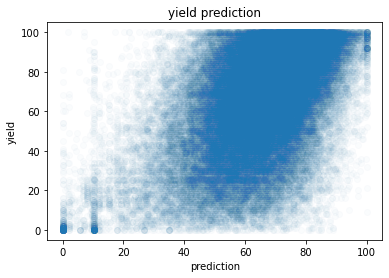

In [14]:
plt.scatter(df['prediction'], df['YIELD'], alpha=0.02)
plt.xlabel('prediction')
plt.ylabel('yield')
plt.title('yield prediction')